<a href="https://colab.research.google.com/github/ashkanfarhangi/AI-for-Trading/blob/master/Evolution_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/UCF_Intelligent Systems/data/Google1819.csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,1048.339966,1066.939941,1045.229980,1065.000000,1065.000000,1237600
1,2018-01-03,1064.310059,1086.290039,1063.209961,1082.479980,1082.479980,1430200
2,2018-01-04,1088.000000,1093.569946,1084.001953,1086.400024,1086.400024,1004600
3,2018-01-05,1094.000000,1104.250000,1092.000000,1102.229980,1102.229980,1279100
4,2018-01-08,1102.229980,1111.270020,1101.619995,1106.939941,1106.939941,1047600


In [3]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

seaborn==0.9.0
pandas==0.24.2
numpy==1.16.3
matplotlib==3.0.3
google==2.0.2


# Deep Evolution Strategy Network:

In [0]:
class DES:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights
#rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
#  self.weights[index] = (
#                     w
#                     + self.learning_rate
#                     / (self.population_size * self.sigma)
#                     * np.dot(A.T, rewards).T
#                 )
    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'Iteration: %d. Return of Investment: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]
#Prediction used to update the weights
    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision
#Weights are being updated after each iteration
    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
class Agent:
    POPULATION_SIZE = 25
    SIGMA = 0.1
    LEARNING_RATE = 0.02

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = DES(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        portfolio = []
        investmentPortfolio =[]
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                portfolio.append(initial_money)
                states_buy.append(t)
                
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                portfolio.append(initial_money)
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                    investmentPortfolio.append(invest)
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest, portfolio ,investmentPortfolio

#Training

In [0]:
#Tweaking goes here
#w 30 ,i 12k,l 300 > S = 36 48
#w 30 ,i 12k,l 300 > S = 29 38 2.5k=54

In [7]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 12000

model = Model(input_size = window_size, layer_size = 300, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 10000, checkpoint = 100)

Iteration: 100. Return of Investment: 37.192001
Iteration: 200. Return of Investment: 46.540745
Iteration: 300. Return of Investment: 49.514911
Iteration: 400. Return of Investment: 51.561994
Iteration: 500. Return of Investment: 51.823413
Iteration: 600. Return of Investment: 51.475746
Iteration: 700. Return of Investment: 51.665579
Iteration: 800. Return of Investment: 51.605494
Iteration: 900. Return of Investment: 52.293829
Iteration: 1000. Return of Investment: 52.045496
Iteration: 1100. Return of Investment: 52.319078
Iteration: 1200. Return of Investment: 52.319078
Iteration: 1300. Return of Investment: 52.611496
Iteration: 1400. Return of Investment: 52.691080
Iteration: 1500. Return of Investment: 52.081079
Iteration: 1600. Return of Investment: 52.603079
Iteration: 1700. Return of Investment: 52.740080
Iteration: 1800. Return of Investment: 52.900247
Iteration: 1900. Return of Investment: 52.835414
Iteration: 2000. Return of Investment: 52.704998
Iteration: 2100. Return of In

In [8]:
states_buy, states_sell, total_gains, invest,portfolio,investmentPortfolio = agent.buy()


day 0: buy 1 unit at price 1065.000000, total balance 10935.000000
day 1: buy 1 unit at price 1082.479980, total balance 9852.520020
day 2, sell 1 unit at price 1086.400024, investment 2.009392 %, total balance 10938.920044,
day 3, sell 1 unit at price 1102.229980, investment 1.824514 %, total balance 12041.150024,
day 12: buy 1 unit at price 1137.510010, total balance 10903.640014
day 14, sell 1 unit at price 1169.969971, investment 2.853598 %, total balance 12073.609985,
day 23: buy 1 unit at price 1055.800049, total balance 11017.809936
day 24: buy 1 unit at price 1080.599976, total balance 9937.209960
day 25: buy 1 unit at price 1048.579956, total balance 8888.630004
day 26: buy 1 unit at price 1001.520020, total balance 7887.109984
day 27: buy 1 unit at price 1037.780029, total balance 6849.329955
day 28: buy 1 unit at price 1051.939941, total balance 5797.390014
day 29: buy 1 unit at price 1052.099976, total balance 4745.290038
day 30, sell 1 unit at price 1069.699951, investment

In [9]:
# print(model.weights)
optimal_weights = pd.DataFrame(model.weights)
print(optimal_weights.shape)
# print(optimal_weights)
#print(model.weights)
x =np.array(model.weights)
x.shape
#print(x)
print("reward 1: ",x[0].shape)
print("reward 2: ",x[1].shape)
print("reward 3: ",x[2].shape)

(3, 1)
reward 1:  (30, 300)
reward 2:  (300, 3)
reward 3:  (1, 300)


#Results:

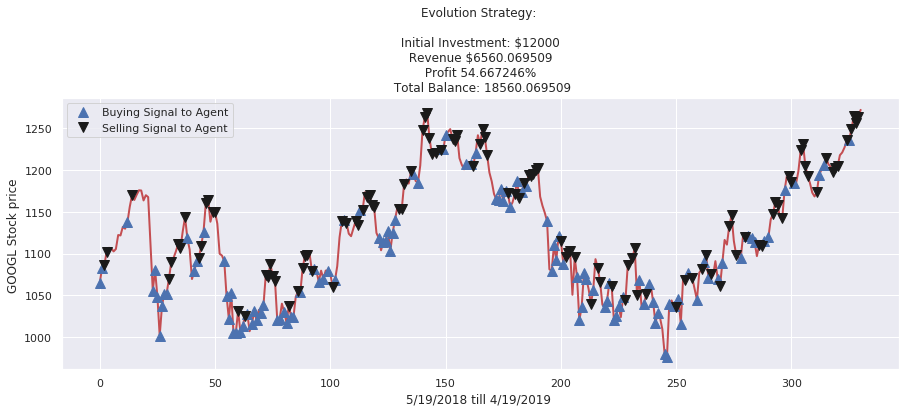

In [10]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='b', label = 'Buying Signal to Agent', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'Selling Signal to Agent', markevery = states_sell)
plt.title('Evolution Strategy: \n \n Initial Investment: $12000 \n Revenue $%f \n Profit %f%% \n Total Balance: %f'%(total_gains, invest,portfolio[-1]))
plt.legend()
plt.ylabel('GOOGL Stock price ') 
plt.xlabel('5/19/2018 till 4/19/2019 ') 

plt.show()

In [0]:
portfolio = pd.DataFrame(portfolio)
investmentPortfolio = pd.DataFrame(investmentPortfolio)
rollingMeanInvest = investmentPortfolio.rolling(window=10).mean()
rollingMeanPort = portfolio.rolling(window=10).mean()


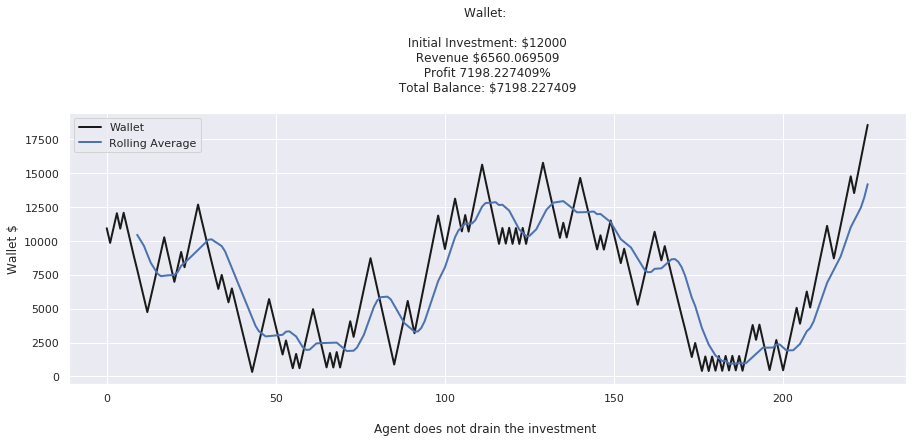

In [12]:
fig = plt.figure(figsize = (15,5))

plt.plot(portfolio, color='k',label = "Wallet", lw=2.)
plt.plot(rollingMeanPort,color='b',label = "Rolling Average", lw=2.)
plt.title('Wallet: \n \n Initial Investment: $12000 \n Revenue $%f \n Profit %f%% \n Total Balance: $%f \n'%(total_gains, portfolio.mean(),portfolio.mean()))
plt.legend()
plt.ylabel('Wallet $') 
plt.xlabel('\nAgent does not drain the investment ')
plt.show()


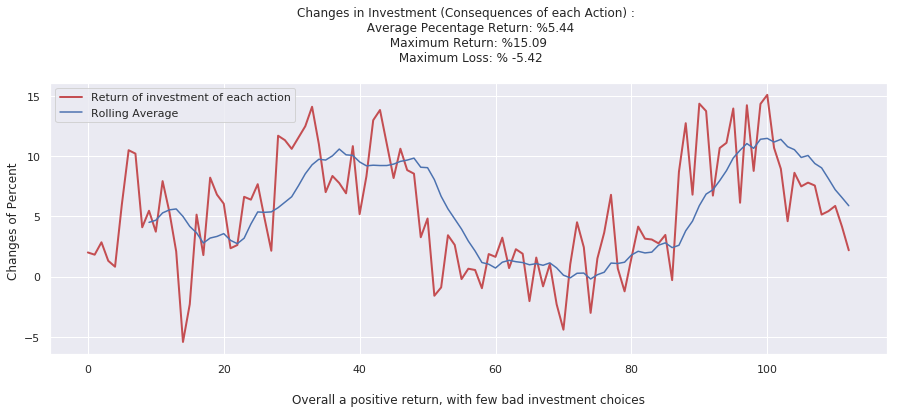

In [13]:
fig = plt.figure(figsize = (15,5))
rollingMean = investmentPortfolio.rolling(window=10).mean()
plt.plot(investmentPortfolio, label = 'Return of investment of each action', color='r', lw=2.)
plt.plot(rollingMean,label = "Rolling Average")
#plt.plot(close, '^', markersize=10, color='b', label = 'Buying Signal to Agent', markevery = states_buy)
plt.title('Changes in Investment (Consequences of each Action) : \n  Average Pecentage Return: %%%.2f \n Maximum Return: %%%.2f \n Maximum Loss: %% %.2f\n'%(investmentPortfolio.mean(),investmentPortfolio.max(),investmentPortfolio.min()))

plt.legend()
plt.ylabel('Changes of Percent ') 
plt.xlabel('\nOverall a positive return, with few bad investment choices') 

plt.show()

In [14]:
investmentPortfolio.describe()

,0
count,113.000000
mean,5.443442
std,4.700906
min,-5.416725
25%,1.902596
50%,5.152408
75%,8.621794
max,15.088600


References:

https://arxiv.org/abs/1703.03864    

https://github.com/openai/evolution-strategies-starter

https://github.com/huseinzol05/Stock-Prediction-Models